# Буканов Никита, Лабораторная работа №6

In [149]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

# Задание №1

Жидкие продукты разливается в пакеты на линии упаковки. Затраты на подвоз 700 у.е. Совокупная потребность в этих продуктах составляет 140 000 литров в месяц. Стоимость хранения 1 литра в течение месяца составляет 4 у.е. Определить оптимальные параметры пополнения склада цеха разлива.

Пусть скорость расходования за какой-то промежуток времени (его определите сами) случайным образом меняется. В этом случае у Вас может образоваться дефицит (отсутствие товара на складе) или переполнение склада (довоз товара еще при его наличии). Чтобы оценить эффективность Вашего управления введите еще одну экономическую характеристику — доход от реализации единицы товара. Объясните, почему на прошлом занятии мы не нуждались в такой характеристике. Постройте график состояния склада за три месяца, а также график дохода. Как, используя статистический анализ, снизить потери

In [150]:
q = 14000
p = 4/30
s = 5

<IPython.core.display.Javascript object>


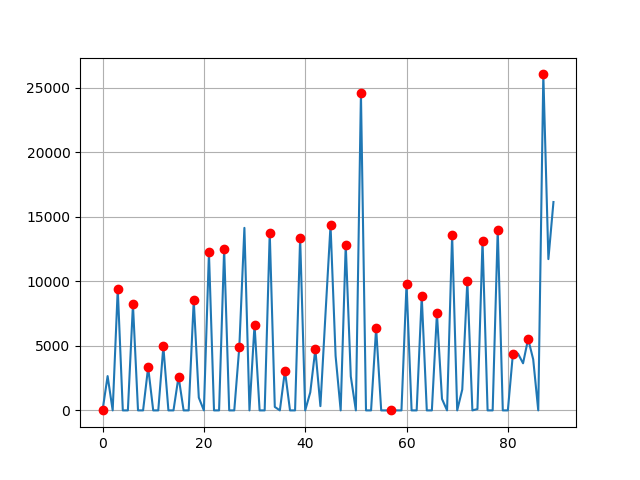

<IPython.core.display.Javascript object>


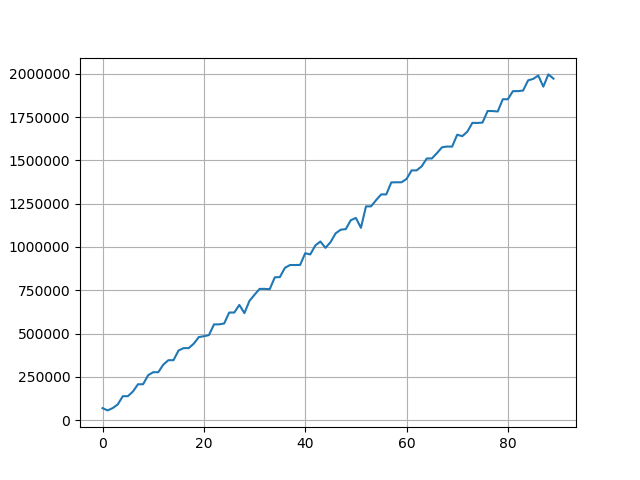

In [90]:
consumption = 140000/30 + 6000 * np.random.randn(90)
storage = np.zeros_like(consumption)

storage[::3] = q
storage = np.cumsum(storage - consumption)
storage[1:][storage[:-1] < 0] -= storage[:-1][storage[:-1] < 0]
storage = np.maximum(storage, 0)

storage_cost = np.cumsum(p*storage)
storage_cost[::3] += 700
buy_cnt = np.zeros_like(consumption)
buy_cnt[::3] = q
buy_cnt = np.cumsum(buy_cnt)

plt.figure()
plt.grid()
plt.plot(storage)
plt.plot(np.array(range(90))[::3], storage[::3], 'ro')

plt.figure()
plt.grid()
plt.plot(s * (buy_cnt - storage) - storage_cost)

# Задание №2

In [348]:
def model(current_state, prediction):
    needed = prediction.sum() - current_state
    N = 10
    part = int(needed/N)
    min_expenses = 10**6
    min_combination = []
    min_boughts = []
    
    
    for d in itertools.product(range(N), repeat = 7):
        if sum(d) == N:
            state = current_state
            expenses = 0
            boughts = np.zeros(7)
            for i, p in enumerate(prediction):
                boughts[i] = min(state, prediction[i])
                state -= boughts[i]
                if d[i] > 0:
                    expenses += 700
                state += d[i]*part
                expenses += state*4/30
                
            if expenses < min_expenses:
                min_boughts = boughts
                min_expenses = expenses / sum(boughts)
                min_combination = np.array(d)*part
    print(min_combination)

In [349]:
N = 90
t = np.linspace(0, N, N+1)
df = pd.DataFrame(5000 + 100*(0.1*t + np.cos(t/7*2*np.pi) + 0.2*np.random.randn(N+1)), 
                      columns=['Потребление'])
df_week = pd.DataFrame(columns=['1', '2', '3', '4', '5', '6', '7'])

<IPython.core.display.Javascript object>


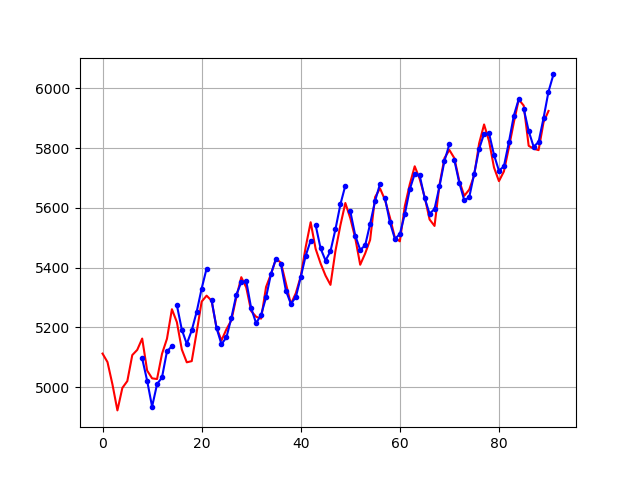

In [350]:
plt.figure()
plt.plot(df.index[::1], df[::1], 'r')
tmp = df[::7]
for i in range(1, len(tmp)):
    k = (tmp.iloc[i]['Потребление'] - tmp.iloc[i-1]['Потребление'])/7

    d = dict()
    for j in range(1,8):
        d[str(j)] = df.iloc[tmp.iloc[i-1].name+j]['Потребление'] - (df.iloc[tmp.iloc[i-1].name]['Потребление'] + j*k)
    df_week = df_week.append(d, ignore_index=True)
    array =  np.array(range(1,8)*k) + tmp.iloc[i]['Потребление'] + df_week.mean().values
    plt.plot(7*i+np.array(range(1,8)), array, 'b.-')
plt.grid()
plt.show()

In [351]:
df_week.mean().values

array([ -43.5306042 , -129.47037367, -194.21795847, -190.16030603,
       -122.12414611,  -45.57726249,    0.        ])

In [352]:
df = pd.DataFrame(500 + 100*(0.1*t + np.sin(t/7*2*np.pi)) + 50*np.random.randn(91), columns=['Потребление'])

df['mean_long'] = df['Потребление'].rolling(7).mean()
df['mean_short'] = df['Потребление'].rolling(3).mean()

df['Баланс Склада №1'] = 0
df['Баланс Склада №2'] = 0

df['Расходы №1'] = 0
df['Расходы №2'] = 0

df['Продаж №1'] = 0
df['Продаж №2'] = 0

df['Точки закупок №1'] = 0
df['Точки закупок №2'] = 0

In [353]:
for index, row in df.iterrows():
    if index == 0:
        df.loc[index, 'Баланс Склада №1'] = q
        df.loc[index, 'Баланс Склада №2'] = q
    else:
        df.loc[index, 'Продаж №1'] = min(df.loc[index-1, 'Баланс Склада №1'], row['Потребление'])
        df.loc[index, 'Продаж №2'] = min(df.loc[index-1, 'Баланс Склада №2'], row['Потребление'])
        
        df.loc[index, 'Баланс Склада №1'] = df.loc[index-1, 'Баланс Склада №1'] - df.loc[index, 'Продаж №1']
        df.loc[index, 'Баланс Склада №1'] = df.loc[index, 'mean_long']
        df.loc[index, 'Расходы №1'] = 700
        df.loc[index, 'Точки закупок №1'] = 1
            
        df.loc[index, 'Баланс Склада №2'] = df.loc[index-1, 'Баланс Склада №2'] - df.loc[index, 'Продаж №2']
        if (df.loc[index, 'mean_short'] > df.loc[index, 'mean_long']) and (df.loc[index-1, 'mean_short'] < df.loc[index-1, 'mean_long']):
            df.loc[index, 'Баланс Склада №2'] = df.loc[index, 'mean_long']*7
            df.loc[index, 'Расходы №2'] = 700
            df.loc[index, 'Точки закупок №2'] = 1
        
        df.loc[index, 'Расходы №1'] = df.loc[index, 'Расходы №1'] + df.loc[index, 'Баланс Склада №1']*4/30
        df.loc[index, 'Расходы №2'] = df.loc[index, 'Расходы №2'] + df.loc[index, 'Баланс Склада №2']*4/30

<IPython.core.display.Javascript object>


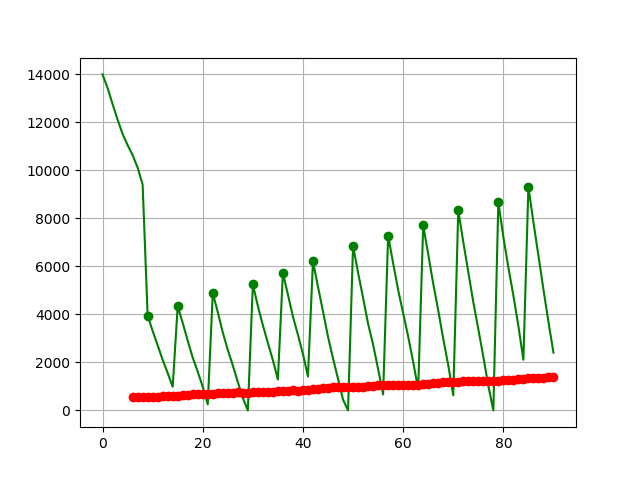

In [354]:
plt.figure()
plt.plot(df.index, df['Баланс Склада №1'], 'r')
plt.plot(df.index, df['Баланс Склада №2'], 'g')

for index, row in df.iterrows():
    if row['Точки закупок №1'] == 1:
        plt.plot(index, row['Баланс Склада №1'], 'ro')
    if row['Точки закупок №2'] == 1:
        plt.plot(index, row['Баланс Склада №2'], 'go')
    
plt.grid()
plt.show()

In [355]:
df['Расходы №1'].sum()/df['Продаж №1'].sum()

0.8971876358682151

In [356]:
df['Расходы №2'].sum()/df['Продаж №2'].sum()

0.7521949996092253

<IPython.core.display.Javascript object>


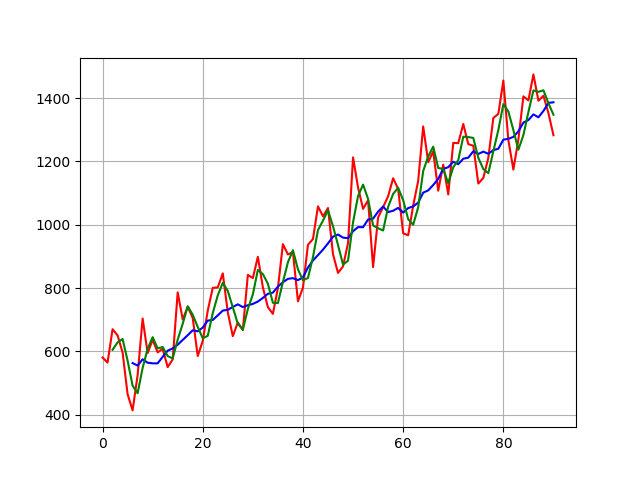

In [357]:
plt.figure()
plt.plot(df.index, df['Потребление'], 'r')
plt.plot(df.index, df['Потребление'].rolling(7).mean(), 'b')
plt.plot(df.index, df['Потребление'].rolling(3).mean(), 'g')
plt.grid()
plt.show()